# Text2SQL

Small mockup example of Text2SQL resolution to search tables starting from users' natural language queries.

For the sake of simplicity, only the core of the multi-agent system is realized, i.e. translation of the natural question into a SQL query + running checks to assure its correctness: it is assumed the table the system has to interrogate has already been chosen and that we obtained its representation in the form of a create table query (`CREATE TABLE ...`); in the end, we also do not actually execute the final SQL query via a tool, but we let an LLM made-up data.

Execution flow:

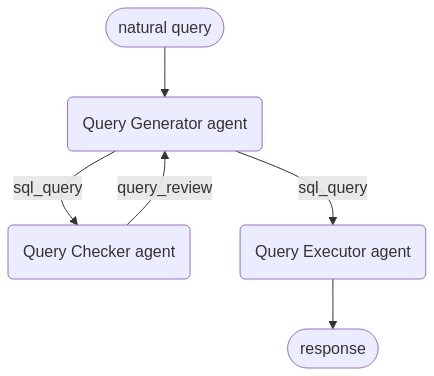

In [21]:
mocked_table_schema = """
CREATE TABLE Employee (
    EmployeeID INT PRIMARY KEY,
    FirstName VARCHAR(50) NOT NULL,
    LastName VARCHAR(50) NOT NULL,
    DateOfBirth DATE,
    HireDate DATE NOT NULL,
    JobTitle VARCHAR(100),
    Salary DECIMAL(10, 2),
    DepartmentID INT,
    Email VARCHAR(100) UNIQUE,
    Phone VARCHAR(15)
);
"""

### task/messages models

In [13]:
from typing import Optional
from pydantic import BaseModel


class SQLQueryGenerationTask(BaseModel):
    user_natural_query: str
    table_definition: str
    review: Optional[str] = None


class SQLQueryGenerationReviewTask(BaseModel):
    user_natural_query: str
    table_definition: str
    sql_query: str


class SQLQueryGenerationReviewResult(
    BaseModel,
):
    user_natural_query: str
    table_definition: str
    sql_query: str
    review: str
    approved: bool


class SQLQueryExecutionTask(BaseModel):
    sql_query: str


class SQLQueryExecutionResult(BaseModel):
    result: str

### completion model

In [14]:
import os
import getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("AZURE_OPENAI_API_KEY")
_set_env("AZURE_OPENAI_ENDPOINT")
_set_env("AZURE_OPENAI_API_VERSION")
_set_env("AZURE_OPENAI_DEPLOYMENT_NAME")
_set_env("AZURE_OPENAI_MODEL_NAME")

In [15]:
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient

model_client: AzureOpenAIChatCompletionClient = AzureOpenAIChatCompletionClient(
    model=os.getenv("AZURE_OPENAI_MODEL_NAME"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
)

In [16]:
from autogen_core.models import UserMessage

llm_result = await model_client.create(
    messages=[
        UserMessage(content="Hi", source="user"),
    ],
    cancellation_token=None,
)
response = llm_result.content
print(response)

Hello! How can I assist you today?


### agents

In [5]:
from enum import StrEnum, auto


class TopicType(StrEnum):
    DEFAULT = auto()


class AgentType(StrEnum):
    SQL_WRITER = auto()
    SQl_REVIEWER = auto()
    SQL_EXECUTOR = auto()
    CLOSURE_AGENT = auto()

In [ ]:
query_gen_system_prompt: str = """
You will be given a table definition string between the tags <TABLE></TABLE>; you will be also given a user natural language query in tags <USER_QUERY></USER_QUERY>.
If available from previous query generation, you can also be provided with a review in tags <PREVIOUS_REVIEW></PREVIOUS_REVIEW>; the review will contain a SQL expert
review of a SQL query you generated for the very same user query.
Your duty is to write a SQL query that will answer the user query by interrogating the SQL table; if review is available, use the expert feedback to guide you.
If the user query does not make sense w.r.t. to the table definition, return a string where you say 'I cannot answer this query given the database data'.
    *
Output only the SQL query or the string 'I cannot answer this query given the database data'. No greetings, preambles, or any other text.
"""
query_gen_user_prompt: str = """
<TABLE>
    {table_def}
</TABLE>

<USER_QUERY>
    {user_query}
</USER_QUERY>

<PREVIOUS_REVIEW>
    {review}
</PREVIOUS_REVIEW>
"""

query_check_system_prompt: str = """
You will be given a table definition string between the tags <TABLE></TABLE>; you will be given the user query formulated in natural language between the tags <USER_QUERY></USER_QUERY>;
you will be also given a SQL query in tags <SQL_QUERY></SQL_QUERY>.
Your duty is: 
    1. check if the user query request can be answered using data in the table definition
    2. if user query can be answered, check if the SQL query is correct given the table definition.

If the user query cannot be answered given the table definition, a correct SQL query could be "I cannot answer this query given the database data" or something along this line.
If the user query can be answered given the table definition, check if the SQL query is correct.

If the SQL query is correct, state it in the review, and set the 'approved' boolean field to 'True'.
If the SQL query is incorrect, state the correct SQL query in the review, and set the 'approved' boolean field to 'False'.
"""
query_check_user_prompt: str = """
<USER_QUERY>
    {user_query}
</USER_QUERY>
<TABLE>
    {table_def}
</TABLE>
<SQL_QUERY>
    {sql_query}
</SQL_QUERY>
"""

query_execute_system_prompt: str = """
You will be given an input between the tags <INPUT></INPUT>; the input could be of two types: 
    1. a well-formatted SQL query
    2. a string where it stated 'I cannot answer this query given the database data'.
Your duty is to generate a response based on the input.

If the input is a well-formatted SQL query, return the result of the query by inventing data; 
otherwise, return the very string where you say 'I cannot answer this query given the database data'."""

query_execute_user_prompt: str = """
<INPUT>
    {input}
</INPUT>
"""

In [17]:
from autogen_core import (
    DefaultTopicId,
    RoutedAgent,
    default_subscription,
    message_handler,
    MessageContext,
    DefaultTopicId,
)
from autogen_core.models import ChatCompletionClient, CreateResult
from autogen_core.models import LLMMessage, SystemMessage


@default_subscription
class SQLWriterAgent(RoutedAgent):
    """SQL Writer Agent"""

    def __init__(self, model_client: ChatCompletionClient):
        super().__init__(
            description="An agent that generates SQL queries from natural language queries"
        )

        if not isinstance(model_client, ChatCompletionClient):
            raise ValueError("model_client must be an instance of ChatCompletionClient")

        if model_client is None:
            raise ValueError("model_client cannot be None")

        self._model_client = model_client
        self._system_messages: list[LLMMessage] = [
            SystemMessage(
                content=query_gen_system_prompt,
            )
        ]

    @message_handler
    async def handle_sql_generation_task(
        self, message: SQLQueryGenerationTask, ctx: MessageContext
    ) -> None:
        """Handle SQL Generation Task"""

        if not isinstance(message, SQLQueryGenerationTask):
            raise ValueError("message must be an instance of SQLQueryGenerationTask")

        if message.table_definition is None:
            raise ValueError("table_definition cannot be None")

        if message.user_natural_query is None:
            raise ValueError("user_natural_query cannot be None")

        # generate response
        response: CreateResult = await self._model_client.create(
            self._system_messages
            + [
                UserMessage(
                    content=query_gen_user_prompt.format(
                        table_def=mocked_table_schema,
                        user_query=message.user_natural_query,
                        review=message.review,
                    ),
                    source=self.metadata["type"],
                )
            ],
            cancellation_token=ctx.cancellation_token,
        )
        assert isinstance(response.content, str)

        # generate a sql gen review task
        sql_review_task: SQLQueryGenerationReviewTask = SQLQueryGenerationReviewTask(
            user_natural_query=message.user_natural_query,
            table_definition=message.table_definition,
            sql_query=response.content,
        )
        await self.publish_message(sql_review_task, topic_id=DefaultTopicId())

    @message_handler
    async def handle_sql_generation_review_task(
        self, message: SQLQueryGenerationReviewResult, ctx: MessageContext
    ) -> None:
        """Handle SQL Generation Review Task"""

        if not isinstance(message, SQLQueryGenerationReviewResult):
            raise ValueError(
                "message must be an instance of SQLQueryGenerationReviewResult"
            )

        # generated query not approved; use review to generate a new one
        if not message.approved:
            new_gen_task: SQLQueryGenerationTask = SQLQueryGenerationTask(
                user_natural_query=message.user_natural_query,
                table_definition=message.table_definition,
                review=message.review,
            )
            await self.publish_message(new_gen_task, topic_id=DefaultTopicId())
        else:
            sql_exec_task: SQLQueryExecutionTask = SQLQueryExecutionTask(
                sql_query=message.sql_query,
                table_definition=message.table_definition,
            )
            await self.publish_message(sql_exec_task, topic_id=DefaultTopicId())

In [18]:
@default_subscription
class SQLCheckerAgent(RoutedAgent):
    """SQL Checker Agent"""

    def __init__(self, model_client: ChatCompletionClient):
        super().__init__(
            description="An agent that generates SQL queries from natural language queries"
        )

        if not isinstance(model_client, ChatCompletionClient):
            raise ValueError("model_client must be an instance of ChatCompletionClient")

        if model_client is None:
            raise ValueError("model_client cannot be None")

        self._model_client = model_client
        self._system_messages: list[LLMMessage] = [
            SystemMessage(
                content=query_check_system_prompt,
            )
        ]

    @message_handler
    async def handle_query_review_task(
        self, message: SQLQueryGenerationReviewTask, ctx: MessageContext
    ) -> None:
        if not isinstance(message, SQLQueryGenerationReviewTask):
            raise ValueError(
                "message must be an instance of SQLQueryGenerationReviewTask"
            )
        if not message.table_definition:
            raise ValueError("table_definition cannot be None")
        if not message.user_natural_query:
            raise ValueError("user_natural_query cannot be None")
        if not message.sql_query:
            raise ValueError("sql_query cannot be None")

        # generate response
        response: CreateResult = await self._model_client.create(
            self._system_messages
            + [
                UserMessage(
                    content=query_check_user_prompt.format(
                        table_def=message.table_definition,
                        user_query=message.user_natural_query,
                        sql_query=message.sql_query,
                    ),
                    source=self.metadata["type"],
                )
            ],
            extra_create_args={"response_format": SQLQueryGenerationReviewResult},
            cancellation_token=ctx.cancellation_token,
        )

        sql_review_result: SQLQueryGenerationReviewResult = (
            SQLQueryGenerationReviewResult.model_validate_json(response.content)
        )

        await self.publish_message(sql_review_result, topic_id=DefaultTopicId())

In [19]:
@default_subscription
class SQLExecutorAgent(RoutedAgent):
    """SQL Executor Agent"""

    def __init__(self, model_client: ChatCompletionClient):
        super().__init__(
            description="An agent that executes SQL queries against the database"
        )

        if not isinstance(model_client, ChatCompletionClient):
            raise ValueError("model_client must be an instance of ChatCompletionClient")

        if model_client is None:
            raise ValueError("model_client cannot be None")

        self._model_client = model_client
        self._system_messages: list[LLMMessage] = [
            SystemMessage(
                content=query_execute_system_prompt,
            )
        ]

    @message_handler
    async def handle_query_execution_task(
        self, message: SQLQueryExecutionTask, ctx: MessageContext
    ) -> None:
        if not isinstance(message, SQLQueryExecutionTask):
            raise ValueError("message must be an instance of SQLQueryExecutionTask")

        # generate response
        response: CreateResult = await self._model_client.create(
            self._system_messages
            + [
                UserMessage(
                    content=query_execute_user_prompt.format(
                        input=message.sql_query,
                    ),
                    source=self.metadata["type"],
                )
            ],
            extra_create_args={"response_format": SQLQueryExecutionResult},
            cancellation_token=ctx.cancellation_token,
        )
        sql_execution_result: SQLQueryExecutionResult = (
            SQLQueryExecutionResult.model_validate_json(response.content)
        )

        await self.publish_message(sql_execution_result, topic_id=DefaultTopicId())

In [10]:
from autogen_core import ClosureContext


async def output_result(
    _agent: ClosureContext, message: SQLQueryExecutionResult, ctx: MessageContext
) -> None:
    print("\n\n")
    print(message.result)

### runtime

In [11]:
from autogen_core import DefaultSubscription, SingleThreadedAgentRuntime, ClosureAgent

runtime = SingleThreadedAgentRuntime()
await SQLWriterAgent.register(
    runtime,
    AgentType.SQL_WRITER,
    lambda: SQLWriterAgent(model_client=model_client),
)
await SQLCheckerAgent.register(
    runtime,
    AgentType.SQl_REVIEWER,
    lambda: SQLCheckerAgent(model_client=model_client),
)
await SQLExecutorAgent.register(
    runtime,
    AgentType.SQL_EXECUTOR,
    lambda: SQLExecutorAgent(model_client=model_client),
)
await ClosureAgent.register_closure(
    runtime,
    AgentType.CLOSURE_AGENT,
    output_result,
    subscriptions=lambda: [DefaultSubscription()],
)

runtime.start()
await runtime.publish_message(
    message=SQLQueryGenerationTask(
        user_natural_query="What is the employees average salary?",
        table_definition=mocked_table_schema,
    ),
    topic_id=DefaultTopicId(),
)

await runtime.stop_when_idle()

/.venv/lib/python3.13/site-packages/autogen_core/_closure_agent.py:121: UserWarning: Message type <class '__main__.SQLQueryGenerationTask'> not in target types (<class '__main__.SQLQueryExecutionResult'>,) of closure_agent/default. Set unknown_type_policy to 'error' to raise an exception, or 'ignore' to suppress this warning.
  warnings.warn(
/.venv/lib/python3.13/site-packages/autogen_core/_closure_agent.py:121: UserWarning: Message type <class '__main__.SQLQueryGenerationReviewTask'> not in target types (<class '__main__.SQLQueryExecutionResult'>,) of closure_agent/default. Set unknown_type_policy to 'error' to raise an exception, or 'ignore' to suppress this warning.
  warnings.warn(
/.venv/lib/python3.13/site-packages/autogen_core/_closure_agent.py:121: UserWarning: Message type <class '__main__.SQLQueryGenerationReviewResult'> not in target types (<class '__main__.SQLQueryExecutionResult'>,) of closure_agent/default. Set unknown_type_policy to 'error' to raise an exception, or 'ig




AverageSalary
-------------
55000.00
